In [ ]:
!pip install qutip

import matplotlib.pyplot as plt
import numpy as np
import qutip
import defs
import helpers_qutip

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


# Generate Training/Validation/Test Sets

In [ ]:
#m = helpers_qutip.Metadata('example_trajectory')

#print('start: {}'.format(m.time_start))

p = defs.get_parameters(num_sites=1, num_fock=[5])
p.print_parameters()

ops = helpers_qutip.Operators(p, swap_tensor_order=True)

h_args = defs.get_hamiltonian(p, ops)
hamiltonian = h_args['H0']
    
c_ops = defs.get_collapse_operators(p, ops)   

# time-evolution
state_plus_z  = defs.get_initial_state(p, ops, state_qb='+ze')
state_minus_z = defs.get_initial_state(p, ops, state_qb='-ze')
state_plus_x  = defs.get_initial_state(p, ops, state_qb='+x')
state_minus_x = defs.get_initial_state(p, ops, state_qb='-x')

# trajectories
result_sme_plus_z = helpers_qutip.solve_time_evolution_trajectories(p,
                                                                    hamiltonian,
                                                                    state_plus_z, 
                                                                    c_ops=[],#[c_ops[1]],
                                                                    sc_ops=[c_ops[0]],
                                                                    ntraj=p.ntraj,
                                                                    nsubsteps=p.nsubsteps)

result_sme_minus_z = helpers_qutip.solve_time_evolution_trajectories(p,
                                                                    hamiltonian,
                                                                    state_minus_z, 
                                                                    c_ops=[],#[c_ops[1]],
                                                                    sc_ops=[c_ops[0]],
                                                                    ntraj=p.ntraj,
                                                                    nsubsteps=p.nsubsteps)

result_sme_plus_x = helpers_qutip.solve_time_evolution_trajectories(p,
                                                                    hamiltonian,
                                                                    state_plus_x, 
                                                                    c_ops=[],#[c_ops[1]],
                                                                    sc_ops=[c_ops[0]],
                                                                    ntraj=p.ntraj,
                                                                    nsubsteps=p.nsubsteps)

result_sme_minus_x = helpers_qutip.solve_time_evolution_trajectories(p,
                                                                    hamiltonian,
                                                                    state_minus_x, 
                                                                    c_ops=[],#[c_ops[1]],
                                                                    sc_ops=[c_ops[0]],
                                                                    ntraj=p.ntraj,
                                                                    nsubsteps=p.nsubsteps)

def extract_trajectory_from_sme(result_sme, expect_op):
    return np.array( [qutip.expect(expect_op, _rho) for _rho in result_sme.states] )    

def plot_trajectories(time, trajectories):
    fig, ax = plt.subplots(figsize=(6,4))
    for trajectory in trajectories:
        ax.plot(time, trajectory)
        ax.set_ylim([-1, 1])
        ax.set_xlabel('Time ($\mu$s)')
        ax.set_ylabel('$<\sigma_z>$')


# Extract trajectories from stochastic master equation solver
trajectory_time = p.times
z_plus_trajectories =  extract_trajectory_from_sme(result_sme_plus_z, ops.Sz[0]) 
z_minus_trajectories = extract_trajectory_from_sme(result_sme_minus_z, ops.Sz[0]) 
x_plus_trajectories =  extract_trajectory_from_sme(result_sme_plus_x, ops.Sz[0]) 
x_minus_trajectories = extract_trajectory_from_sme(result_sme_minus_x, ops.Sz[0]) 

np.save('datasets/trajectory_time.npy',      trajectory_time)
np.save('datasets/z_plus_trajectories.npy',  z_plus_trajectories)
np.save('datasets/z_minus_trajectories.npy', z_minus_trajectories)
np.save('datasets/x_plus_trajectories.npy',  x_plus_trajectories)
np.save('datasets/x_minus_trajectories.npy', x_minus_trajectories)



solver: mesolve
num_pts: 501


10.0%. Run time:   2.03s. Est. time left: 00:00:00:18
20.0%. Run time:   4.10s. Est. time left: 00:00:00:16
30.0%. Run time:   6.69s. Est. time left: 00:00:00:15
40.0%. Run time:   9.06s. Est. time left: 00:00:00:13
50.0%. Run time:  11.40s. Est. time left: 00:00:00:11
60.0%. Run time:  13.83s. Est. time left: 00:00:00:09
70.0%. Run time:  17.46s. Est. time left: 00:00:00:07
80.0%. Run time:  19.62s. Est. time left: 00:00:00:04
90.0%. Run time:  21.68s. Est. time left: 00:00:00:02
Total run time:  23.91s
10.0%. Run time:   2.58s. Est. time left: 00:00:00:23
20.0%. Run time:   4.75s. Est. time left: 00:00:00:19
30.0%. Run time:   6.76s. Est. time left: 00:00:00:15
40.0%. Run time:   8.92s. Est. time left: 00:00:00:13
50.0%. Run time:  11.53s. Est. time left: 00:00:00:11
60.0%. Run time:  15.12s. Est. time left: 00:00:00:10
70.0%. Run time:  17.39s. Est. time left: 00:00:00:07
80.0%. Run time:  19.57s. Est. time left: 00:00:00:04
90.0%. Run time:  22.06s.

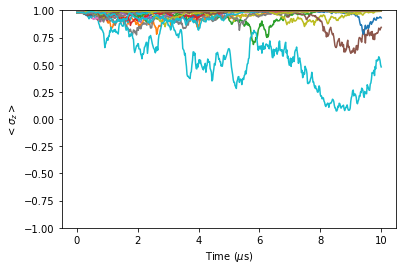

In [ ]:
plot_trajectories(trajectory_time, z_plus_trajectories)

# Classify with One-Box Method

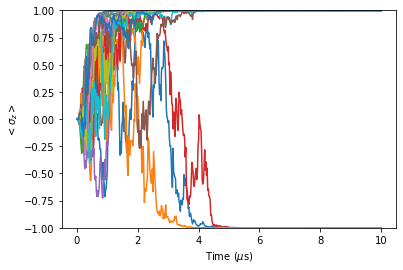

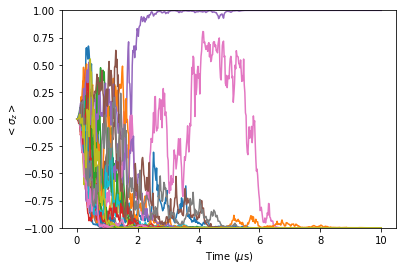

In [ ]:
skip_time = 40e-9 * 1e6 # in us
integration_time = 2e-6 * 1e6

def single_box_classifier(time, trajectories, skip_time, integration_time):
    # extract points after skip time, but before integration time is complete
    integration_start = np.argmax(time >= skip_time)
    integration_end = np.argmin(time <= (skip_time + integration_time))
    #valid_times = time[integration_start:integration_end]
    valid_trajectories = trajectories[:, integration_start:integration_end]

    return valid_trajectories.mean(axis=1)

one_box_means = single_box_classifier(trajectory_time, x_minus_trajectories, skip_time, integration_time)

# Extract ground and excited states, plot them
z_minus_states = []
z_plus_states = []
for i, mean in enumerate(one_box_means):
    if(mean < 0):
        z_minus_states.append(x_minus_trajectories[i])

    else:
        z_plus_states.append(x_minus_trajectories[i])

z_plus_states = np.array(z_plus_states)
z_minus_states = np.array(z_minus_states)

plot_trajectories(trajectory_time, z_plus_states)
plot_trajectories(trajectory_time, z_minus_states)        

# Classify with Two-Box Method

50 trajectories in simulation
22 trajectories in z_plus
28 trajectories in z_minus
0 trajectories in misc


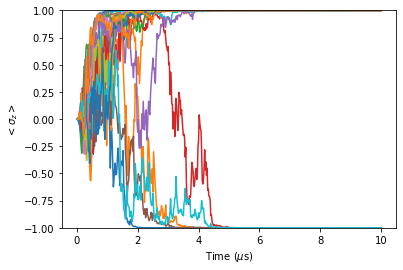

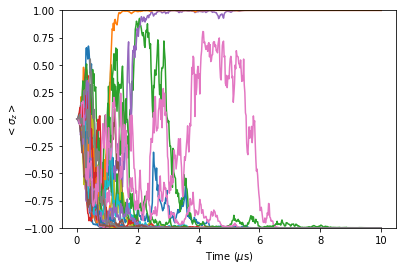

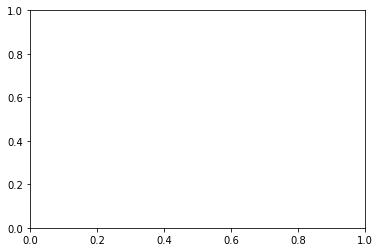

In [ ]:
def double_box_classifier(time, trajectories, skip_time, integration_time):
    # extract points after skip time, but before integration time is complete
    integration_start = np.argmax(time >= skip_time)
    integration_end = np.argmin(time <= (skip_time + integration_time))
    #valid_times = time[integration_start:integration_end]
    valid_trajectories = trajectories[:, integration_start:integration_end]

    # compute windowed averages
    midpoint = valid_trajectories.shape[1]//2
    first_half =  valid_trajectories[:, :midpoint]
    second_half = valid_trajectories[:, midpoint:]


    return np.array([first_half.mean(axis=1), second_half.mean(axis=1)])

two_box_means = double_box_classifier(trajectory_time, x_minus_trajectories, skip_time, integration_time)
box_one_means = two_box_means[0]
box_two_means = two_box_means[1]

z_minus_states = []
z_plus_states = []
misc_states = []

for i in range(box_one_means.shape[0]):
    if( (box_one_means[i] >= 0) and (box_one_means[i] >= 0) ):
        z_plus_states.append(x_minus_trajectories[i])
    
    elif( (box_one_means[i] <= 0) and (box_one_means[i] <= 0) ):
        z_minus_states.append(x_minus_trajectories[i])
    
    else:
        misc_states.append(x_minus_trajectories[i])

z_plus_states = np.array(z_plus_states)
z_minus_states = np.array(z_minus_states)
misc_states = np.array(misc_states)

plot_trajectories(trajectory_time, z_plus_states)
plot_trajectories(trajectory_time, z_minus_states)
plot_trajectories(trajectory_time, misc_states)

print(f"{x_minus_trajectories.shape[0]} trajectories in simulation")
print(f"{z_plus_states.shape[0]} trajectories in z_plus")
print(f"{z_minus_states.shape[0]} trajectories in z_minus")
print(f"{misc_states.shape[0]} trajectories in misc")

# Classify with Multi-Layer Perceptron

In [ ]:
# https://scikit-learn.org/stable/modules/neural_networks_supervised.html

from sklearn.neural_network import MLPClassifier
#classifier = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
classifier = MLPClassifier(solver='lbfgs', alpha=1e-5, random_state=1)
X = np.vstack((z_plus_states, z_minus_states))
Y = np.concatenate((np.ones(z_plus_states.shape[0]), -np.ones(z_minus_states.shape[0])))

classifier.fit(X,Y)

MLPClassifier(alpha=1e-05, random_state=1, solver='lbfgs')

In [ ]:
classifier.predict([z_minus_states[4]])

array([-1.])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0211f19d-54e4-44e5-ab1c-ce7a6a2d44df' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>